In [1]:
from models import MIQPPlanner, CurvState
from commonroad.common.file_reader import CommonRoadFileReader
from commonroad_dc.pycrccosy import CurvilinearCoordinateSystem
from commonroad_route_planner.route_planner import RoutePlanner
import os



## `Planning problem defined in scenario`

In [2]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from IPython.display import clear_output
from commonroad.visualization.mp_renderer import MPRenderer
from commonroad_route_planner.utility.visualization import visualize_route, draw_state

scenario_path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), "../scenarios/ZAM_Tutorial-1_2_T-1.xml"))
scenario, planning_problem_set = CommonRoadFileReader(scenario_path).open()
planning_problem = list(planning_problem_set.planning_problem_dict.values())[0] #* get the first(and the only one) planning_problem_dict value
# print(planning_problem_set.planning_problem_dict.keys()) #* only one planning problem in the set


scenario.remove_obstacle(scenario.static_obstacles)
scenario.remove_obstacle(scenario.dynamic_obstacles)
#! planning_problem goal is empty.
goal = planning_problem.goal
p_id = planning_problem.planning_problem_id
goal_lanelets = goal.lanelets_of_goal_position
goal_state = goal.state_list
initial_state =planning_problem.initial_state
print('Goal: ', goal_lanelets, goal_state)
print('\nInitial State:', initial_state)
print("Id of planning problem: {}".format(p_id))

Goal:  None []

Initial State: 
position= [15.  0.]
orientation= 0.0
velocity= 22.0
yaw_rate= 0.0
slip_angle= 0.0
time_step= 0

Id of planning problem: 100


## `Show Scenario`

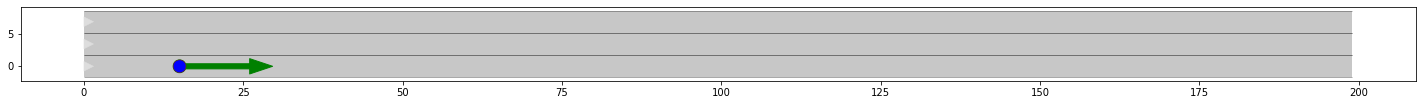

In [3]:
plt.figure(figsize=(25, 10))#! define renderer after figure creation
renderer = MPRenderer()
scenario.draw(renderer, draw_params={'time_begin': 0}) #! draw_params
planning_problem_set.draw(renderer, draw_params={'time_begin': 0}) 
renderer.draw_ellipse(initial_state.position, 1, 1, {'facecolor': 'blue'}, ()) # draw a circle
renderer.render()
plt.show()

## `Reference path`

/home/wang/anaconda3/envs/commonroad-py37/lib/python3.7/site-packages/commonroad_route_planner/route.py:309: RuntimeWarning: invalid value encountered in true_divide
  return (x_d * y_dd - x_dd * y_d) / ((x_d ** 2 + y_d ** 2) ** (3. / 2.))



Coordinates [x, y]:
[[0.00000e+00 0.00000e+00]
 [7.81250e-03 0.00000e+00]
 [2.34375e-02 0.00000e+00]
 ...
 [1.94000e+02 0.00000e+00]
 [1.94000e+02 0.00000e+00]
 [1.94000e+02 0.00000e+00]]


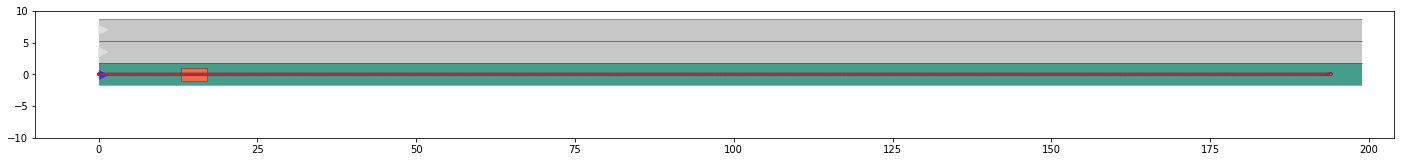

In [4]:
# create the curvilinear coordinate based on a reference path
route_planner = RoutePlanner(scenario, planning_problem, backend=RoutePlanner.Backend.NETWORKX_REVERSED)
#* NETWORKX: uses built-in functions from the networkx package, tends to change lanes later
#* NETWORKX_REVERSED: uses built-in functions from the networkx package, tends to change lanes earlier
#* PRIORITY_QUEUE: uses A-star search to find routes, lane change maneuver depends on the heuristic cost


# plan routes, and save the routes in a route candidate holder
candidate_holder = route_planner.plan_routes()
route = candidate_holder.retrieve_first_route()
ref_path = route.reference_path

print("\nCoordinates [x, y]:")
print(ref_path)  # 1584 * 2 
visualize_route(route, draw_route_lanelets=True, draw_reference_path=True, size_x=25)

#! Q:
#? The initial state defined in planning_problem is not the same as reference path's initial state


## `Reference path -> curveilinear system`

In [5]:
curvilinear_cosy = CurvilinearCoordinateSystem(ref_path, 25.0, 0.1) #* --> curv_sys
#* reference_path – 2D polyline in Cartesian coordinates
#* default_projection_domain_limit – maximum absolute distance of the projection domain border from the reference path, defaults to 20
#* eps – reduces the lateral distance of the projection domain border from the reference path, defaults to 0.1

print(len(curvilinear_cosy.projection_domain()))
print(curvilinear_cosy.reference_path()[-1])

curv_sys = curvilinear_cosy  # insert CurvilinearCoordinateSystem
# curv_sys.compute_and_set_curvature()
# print(curv_sys.get_curvature() )

3173
[194.   0.]


## `target lanelet`

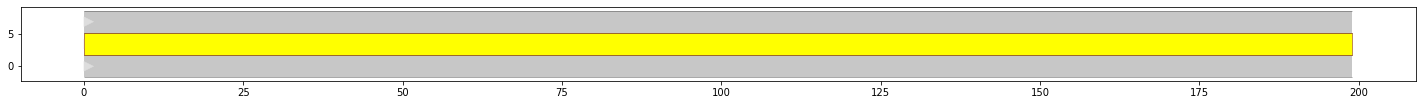

In [6]:

target_lanelet = scenario.lanelet_network.find_lanelet_by_id(2)  # TODO: insert target lane as Lanelet

#* Show target lanelet
plt.figure(figsize=(25, 10))#! define renderer after figure creation
renderer = MPRenderer()
scenario.draw(renderer, draw_params={'time_begin': 0}) #! draw_params
target_lanelet.convert_to_polygon().draw(renderer, draw_params={'facecolor': 'yellow'})
# print(target_lanelet.convert_to_polygon().vertices)
renderer.render()
plt.show()

In [8]:
init_state_curvlinear = CurvState(s=initial_state.position[0], ds=5.0, dds=0.0)  # example; s: x-direction
nT=120 # n_time_steps
dt=0.2 # duration of each time_step


planner = MIQPPlanner(init_state_curvlinear, n_time_steps=nT, min_duration=[0.2, 1.4, 0.2], dt=dt, curv_sys=curv_sys)


# S_param = ScenarioParams()
# planner = MIQPPlanner(init_state_curvlinear, n_time_steps=nT, min_duration=[0.2, 1.0, 0.2], dt=dt, curv_sys=curv_sys, S_param) 


# longitudinal constraints
s_constraints = [np.array([[0, 20]]*nT),  # initial lane  #! element shape 30 * 2, List length 3
                    np.array([[5, 20]]*nT),  # during lane change
                    np.array([[5, 200]]*nT)]  # target lane

planner.set_long_constraints(s_constraints)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-05


In [9]:
planner.model.update()
# planner.model.display()

In [10]:
long_state_list, time_intervals = planner.solve_longitudinal()

Update succeeds.
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1684 rows, 843 columns and 5158 nonzeros
Model fingerprint: 0x07829c2c
Model has 240 quadratic objective terms
Variable types: 483 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-02, 2e+01]
  Bounds range     [1e+00, 8e+02]
  RHS range        [1e+00, 5e+02]
Presolve removed 1437 rows and 478 columns
Presolve time: 0.17s
Presolved: 247 rows, 365 columns, 1088 nonzeros
Presolved model has 239 quadratic objective terms
Variable types: 365 continuous, 0 integer (0 binary)
Root relaxation presolve removed 1 rows and 1 columns
Root relaxation presolve time: 0.35s
Root relaxation presolved: 246 rows, 364 columns, 1086 nonzeros
Root relaxation presolved model has 239 quadratic objective terms
Root barrier log...

Ordering 

In [11]:
for i in range(3):
    print('mode {}:'.format(i), time_intervals[i].length+1)
print('----------------------------------------------')
targe_center_line = target_lanelet.center_vertices # TODO


mode 0: 1
mode 1: 8
mode 2: 111
----------------------------------------------


In [12]:
# for v in planner.model.getVars():
#     print(v.varName, v.X)

In [13]:
planner.solve_lateral(targe_center_line, time_intervals)


/home/wang/文档/KI/CommonRoad/mpfav-ss22-mip-planner-dev_BinghuiWen/examples/models.py:179: UserWarning: Lanes might diverge after s= 194.00029999999998!
  warnings.warn('Lanes might diverge after s= {}!'.format(pos_map[-1][0]))


                                     CVXPY                                     
                                     v1.2.0                                    
(CVXPY) May 12 03:02:33 PM: Your problem has 483 variables, 601 constraints, and 0 parameters.
(CVXPY) May 12 03:02:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 12 03:02:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 12 03:02:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 12 03:02:33 PM: Compiling problem (target solver=OSQP).
(CVXPY) May 12 03:02:33 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuff

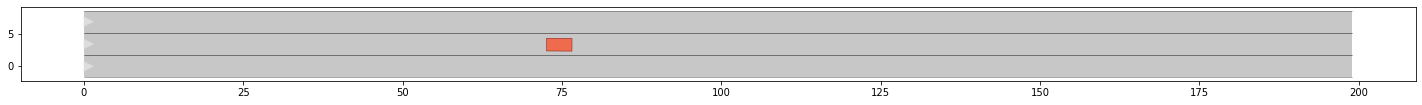

In [25]:
curvilinear_state_list = planner.states.state_list_cr



for i in range(len(curvilinear_state_list)):
    plt.figure(figsize=(25, 10))
    renderer = MPRenderer()
    
    clear_output(wait=True)    
    scenario.draw(renderer, draw_params={'time_begin': i*dt})
    draw_state(renderer, curvilinear_state_list[i])

    
    renderer.render()
    plt.show()





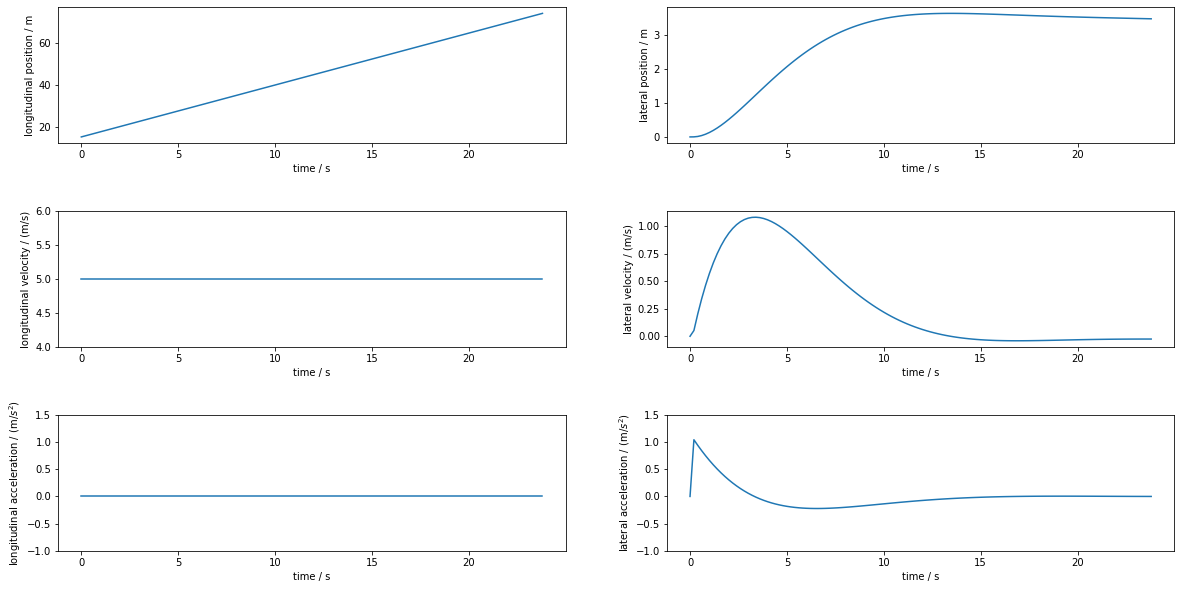

In [132]:
T = np.arange(0, nT*dt, dt)
x = np.empty(nT)
vx = np.empty(nT)
ax = np.empty(nT)
y = np.empty(nT)
vy = np.empty(nT)
ay = np.empty(nT)

for i in range(nT):
    ax[i] = planner.states.state_list[i].dds_float
    vx[i] = planner.states.state_list[i].ds_float
    x [i] = planner.states.state_list[i].s_float
    ay[i] = planner.states.state_list[i].ddd
    vy[i] = planner.states.state_list[i].dd
    y [i] = planner.states.state_list[i].d

fig, axis = plt.subplots(3, 2, figsize=(20, 10))
#longitudinal visualization
axis[2,0].set_xlabel("time / s") 
axis[2,0].set_ylabel("longitudinal acceleration / (m/${s^2}$)")
axis[2,0].set_ylim([-1, 1.5])
axis[2,0].plot(T, ax)

axis[1,0].set_xlabel("time / s") 
axis[1,0].set_ylabel("longitudinal velocity / (m/s)")
axis[1,0].set_ylim([4, 6])
axis[1,0].plot(T, vx)

axis[0,0].set_xlabel("time / s") 
axis[0,0].set_ylabel("longitudinal position / m")
axis[0,0].plot(T, x)

#lateral visualization
axis[2,1].set_xlabel("time / s")
axis[2,1].set_ylim([-1, 1.5])
axis[2,1].set_ylabel("lateral acceleration / (m/${s^2}$)")
axis[2,1].plot(T, ay)

axis[1,1].set_xlabel("time / s") 
axis[1,1].set_ylabel("lateral velocity / (m/s)")
axis[1,1].plot(T, vy)

axis[0,1].set_xlabel("time / s") 
axis[0,1].set_ylabel("lateral position / m")
axis[0,1].plot(T, y)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()